# Projet Gustave Malachane Kilian Violet

In [1]:
!py -m pip install requests

In [2]:
import urllib.request
import json
import pandas as pd
import requests
import shutil
import os

def download_image(url, name):

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        with open("./images/"+name+".jpg", "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code


url = "https://query.wikidata.org/sparql?query=Select%20%3Fvolcan%20%3Fimage%20%3Flabel_pays%20%3Fhauteur%20%3Flabel%20%7B%0A%20%20%3Fvolcan%20wdt%3AP31%20wd%3AQ169358%3B%0A%20%20%20%20%20%20%20%20wdt%3AP18%20%3Fimage%3B%0A%20%20%20%20%20%20%20%20wdt%3AP17%20%3Fpays%3B%0A%20%20%20%20%20%20%20%20wdt%3AP2660%20%3Fhauteur%3B%0A%20%20%20%20%20%20%20%20rdfs%3Alabel%20%3Flabel.%0A%20%20%0A%20%20%3Fpays%20rdfs%3Alabel%20%3Flabel_pays.%0A%20%20%0A%20%20FILTER(lang(%3Flabel)%3D%22en%22%20%26%26%20lang(%3Flabel_pays)%3D%22en%22)%0A%7D%0A%0ALIMIT%20150&format=json"
response = urllib.request.urlopen(url)
responsedata = json.loads(response.read().decode("utf-8"))

array = []
metadata_list = []
i = 1
for data in responsedata["results"]["bindings"]:

    metadata = {
        "nom": data["label"]["value"],
        "hauteur": data["hauteur"]["value"],
        "pays": data["label_pays"]["value"]            
    }

    metadata_list.append(metadata)
    response = download_image(str(data["image"]["value"]).replace("%20", "_").replace("%C3%A1", "a"), metadata["nom"])
    
    i += 1
    
dataframe = pd.DataFrame(array, columns=["label", "image"])

with open("metadata.json", "w", encoding="utf-8") as json_file:
    json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)

## Récupération des données exifs des images

Ici grâce à la librairie PIL & exifread, nous pouvons accéder aux données exifs de l'image. elles sont ensuite stockées dans le fichier JSON metadata.json

In [3]:
!py -m pip install exifread

In [4]:
import os
import json
from PIL import Image
import exifread
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image


def get_dominant_colors(image_path, k=5):
    """ Extrait les k couleurs dominantes d'une image avec K-Means """
    with Image.open(image_path) as img:
        img = img.resize((100, 100))  # Réduire la taille pour accélérer le clustering
        img_array = np.array(img).reshape(-1, 3)  # Convertir en tableau de pixels

    # Clustering des couleurs
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(img_array)

    # Convertir les couleurs en hexadécimal
    colors = ['#%02x%02x%02x' % tuple(map(int, color)) for color in kmeans.cluster_centers_]
    return colors

# Dossier contenant les images
image_folder = "images"

# Parcourir chaque fichier image
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    try:
        # Ouvrir l'image avec PIL
        with Image.open(image_path) as img:
            width, height = img.size
            format_img = img.format

            colors = get_dominant_colors(image_path)

            # Déterminer l'orientation
            if width > height:
                orientation = "Paysage"
            elif height > width:
                orientation = "Portrait"
            else:
                orientation = "Carré"

        # Lire les métadonnées EXIF
        with open(image_path, "rb") as img_file:
            tags = exifread.process_file(img_file, details=False)
            date_creation = tags.get("EXIF DateTimeOriginal", "Inconnu")
            camera_model = tags.get("Image Model", "Inconnu")

        # Stocker les métadonnées dans un dictionnaire
        metadataIndex = next((i for i, md in enumerate(metadata_list) if md["nom"]+".jpg" == image_name), -1)
        
        exif = {
            "nom": image_name,
            "chemin": image_path,
            "taille": f"{width}x{height}",
            "format": format_img,
            "orientation": orientation,
            "date_creation": str(date_creation),
            "modele_camera": str(camera_model),
            "colors": colors,
        }

        metadata_list[metadataIndex]["image"] = exif

    except Exception as e:
        print(f"⚠️ Erreur avec {image_name} : {e}")

# Sauvegarder les métadonnées en JSON
with open("metadata.json", "w", encoding="utf-8") as json_file:
    json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)

print("\n Métadonnées enregistrées dans metadata.json")


c:\Users\gusti\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\gusti\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\gusti\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gusti\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, in _

⚠️ Erreur avec Mount Ragang.jpg : Image size (768777555 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

 Métadonnées enregistrées dans metadata.json


In [5]:
import json
import random

# Charger les volcans depuis un fichier JSON
with open("metadata.json", "r", encoding="utf-8") as f:
    volcans = json.load(f)

# Vérifier le nombre total de volcans
nombre_total_volcans = len(volcans)
print(f"Nombre total de volcans chargés : {nombre_total_volcans}")

# Génération de 50 utilisateurs fictifs
utilisateurs = [
    {"id": i, "nom": f"Utilisateur_{i}", "volcans_consultés": []}
    for i in range(1, 51)
]

# Attribution aléatoire des volcans consultés (en enregistrant uniquement le nom)
for utilisateur in utilisateurs:
    nb_volcans = random.randint(5, 20)  # Chaque utilisateur consulte entre 5 et 20 volcans
    volcans_choisis = random.sample(volcans, min(nb_volcans, nombre_total_volcans))
    
    # Stocker uniquement le nom des volcans
    utilisateur["volcans_consultés"] = [volcan["nom"] for volcan in volcans_choisis]

# Sauvegarde des données dans un fichier JSON
with open("utilisateurs_volcans.json", "w", encoding="utf-8") as f:
    json.dump(utilisateurs, f, indent=4, ensure_ascii=False)

# Affichage d'un aperçu des 5 premiers utilisateurs
print(json.dumps(utilisateurs[:5], indent=4, ensure_ascii=False))  # Afficher les 5 premiers utilisateurs


Nombre total de volcans chargés : 130
[
    {
        "id": 1,
        "nom": "Utilisateur_1",
        "volcans_consultés": [
            "Rinjani",
            "Mount Vesuvius",
            "Antisana volcano",
            "Acotango",
            "Imbabura Volcano",
            "Kronotsky",
            "Gunung Raung",
            "Mount Akutan",
            "Vulcano",
            "Volcán Tajumulco",
            "Mount Apo",
            "Tungurahua volcano",
            "Pular",
            "Mount Kazbek",
            "Otake",
            "Ollagüe",
            "Gunung Slamet",
            "Cerro Paniri",
            "Mount Ragang",
            "Mount Adams"
        ]
    },
    {
        "id": 2,
        "nom": "Utilisateur_2",
        "volcans_consultés": [
            "Licancabur",
            "Opala",
            "Mayon Volcano",
            "Mount Sinabung",
            "Seonginbong",
            "Mount St. Helens",
            "Cayambe",
            "Iztaccihuatl",
            "Am

In [ ]:
#j'ai créé 50 utilisateurs via un script python, et ais ajouter les volcans de manière aléatoire grace à random.

🔹 Top 3 Couleurs: [('#76a6d7', 15), ('#354732', 15), ('#86888b', 15)]
🔹 Top 3 Orientations: [('Paysage', 573), ('Portrait', 31)]
🔹 Top 3 Tailles d'image: [('Moyenne', 250), ('Petite', 180), ('Grande', 174)]
🔹 Top 3 Pays: [('Indonesia', 98), ('United States', 95), ('Chile', 76)]
🔹 Top 3 Balises: [('Mount', 215), ('Volcano', 47), ('volcano', 34)]


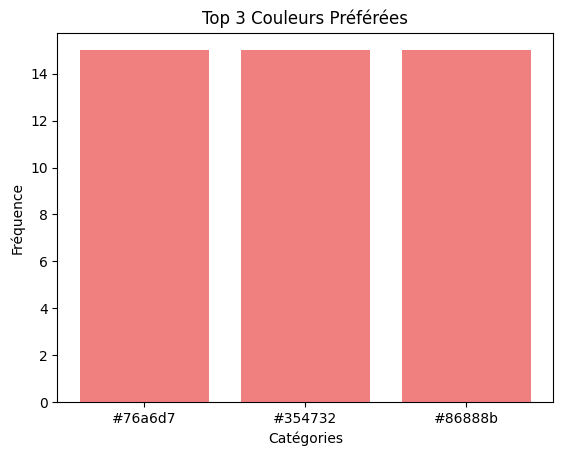

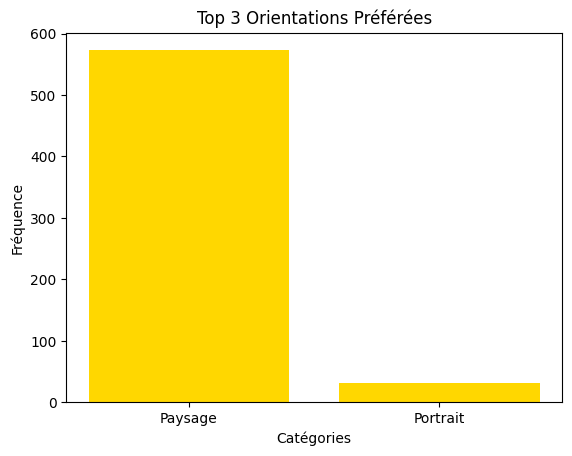

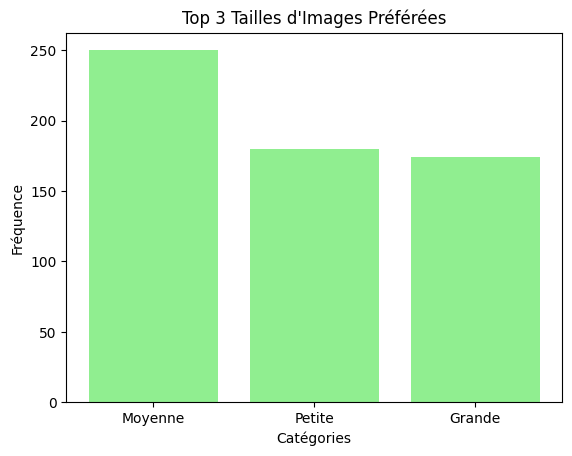

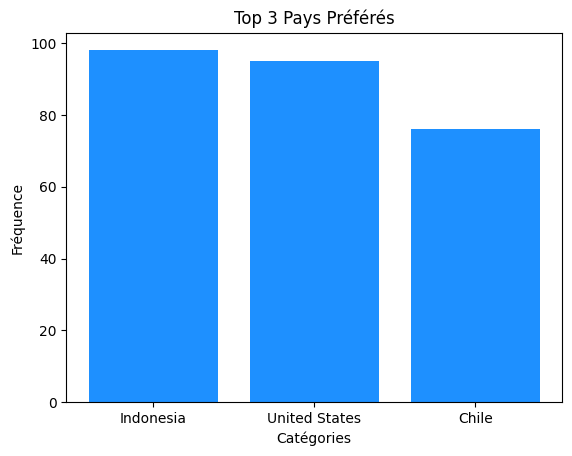

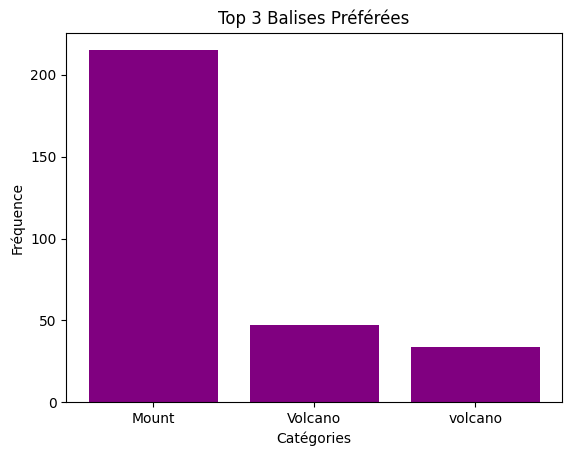

In [25]:
import json
import collections
import matplotlib.pyplot as plt

# Charger les données
with open("metadata.json", "r", encoding="utf-8") as f:
    volcans = json.load(f)

with open("utilisateurs_volcans.json", "r", encoding="utf-8") as f:
    utilisateurs = json.load(f)

# Initialisation des compteurs globaux
global_colors = collections.Counter()
global_orientations = collections.Counter()
global_sizes = collections.Counter()
global_countries = collections.Counter()
global_tags = collections.Counter()

# Analyse des volcans consultés par tous les utilisateurs
for utilisateur in utilisateurs:
    unique_volcans = set(utilisateur["volcans_consultés"])  # Évite les doublons par utilisateur

    for nom_volcan in unique_volcans:
        volcan_data = next((v for v in volcans if v["nom"] == nom_volcan), None)
        if volcan_data:
            if "image" in volcan_data:  # Vérifie si 'image' existe
                global_colors.update(volcan_data["image"].get("colors", []))
                global_orientations[volcan_data["image"].get("orientation", "Inconnu")] += 1

                if "taille" in volcan_data["image"]:
                    largeur, hauteur = map(int, volcan_data["image"]["taille"].split("x"))
                    if largeur < 1000:
                        global_sizes["Petite"] += 1
                    elif largeur < 3000:
                        global_sizes["Moyenne"] += 1
                    else:
                        global_sizes["Grande"] += 1

            global_countries[volcan_data["pays"]] += 1
            mots_cles = volcan_data["nom"].replace("-", " ").replace("_", " ").split()
            global_tags.update(mots_cles)

# Récupérer le top 3 pour chaque catégorie
top_3_colors = global_colors.most_common(3)
top_3_orientations = global_orientations.most_common(3)
top_3_sizes = global_sizes.most_common(3)
top_3_countries = global_countries.most_common(3)
top_3_tags = global_tags.most_common(3)

# Affichage des résultats
print("🔹 Top 3 Couleurs:", top_3_colors)
print("🔹 Top 3 Orientations:", top_3_orientations)
print("🔹 Top 3 Tailles d'image:", top_3_sizes)
print("🔹 Top 3 Pays:", top_3_countries)
print("🔹 Top 3 Balises:", top_3_tags)

# Fonction pour tracer les graphiques
def plot_top_3(title, data, color="skyblue"):
    labels, values = zip(*data)  # Séparer les labels et valeurs
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xlabel("Catégories")
    plt.ylabel("Fréquence")
    plt.show()

# Création des graphiques pour chaque catégorie
plot_top_3("Top 3 Couleurs Préférées", top_3_colors, color="lightcoral")
plot_top_3("Top 3 Orientations Préférées", top_3_orientations, color="gold")
plot_top_3("Top 3 Tailles d'Images Préférées", top_3_sizes, color="lightgreen")
plot_top_3("Top 3 Pays Préférés", top_3_countries, color="dodgerblue")
plot_top_3("Top 3 Balises Préférées", top_3_tags, color="purple")


In [26]:
import json
import collections
import pandas as pd

# Charger les données des volcans et des utilisateurs
with open("metadata.json", "r", encoding="utf-8") as f:
    volcans = json.load(f)

with open("utilisateurs_volcans.json", "r", encoding="utf-8") as f:
    utilisateurs = json.load(f)

# Fonction pour recommander des volcans à un utilisateur
def recommander_volcans(utilisateur):
    # Comptage des préférences de l'utilisateur
    user_countries = collections.Counter()
    user_tags = collections.Counter()
    user_colors = collections.Counter()

    # Récupération des volcans consultés par l'utilisateur
    unique_volcans = set(utilisateur["volcans_consultés"])

    for nom_volcan in unique_volcans:
        volcan_data = next((v for v in volcans if v["nom"] == nom_volcan), None)
        if volcan_data:
            # Ajout du pays
            user_countries[volcan_data["pays"]] += 1
            # Ajout des balises
            mots_cles = volcan_data["nom"].replace("-", " ").replace("_", " ").split()
            user_tags.update(mots_cles)
            # Ajout des couleurs
            if "image" in volcan_data:
                user_colors.update(volcan_data["image"].get("colors", []))

    # Déterminer les préférences principales
    top_countries = [c[0] for c in user_countries.most_common(3)]
    top_tags = [t[0] for t in user_tags.most_common(3)]
    top_colors = [col[0] for col in user_colors.most_common(3)]

    # Création d'une liste de volcans avec un score
    recommandations = []

    for volcan in volcans:
        score = 0

        # Vérification du pays
        if volcan["pays"] in top_countries:
            score += 3
        
        # Vérification des balises
        volcans_tags = volcan["nom"].replace("-", " ").replace("_", " ").split()
        for tag in top_tags:
            if tag in volcans_tags:
                score += 2

        # Vérification des couleurs
        if "image" in volcan:
            for color in top_colors:
                if color in volcan["image"].get("colors", []):
                    score += 1

        # Ajouter à la liste des recommandations si le score est > 0
        if score > 0:
            recommandations.append({
                "volcan": volcan["nom"],
                "pays": volcan["pays"],
                "score": score
            })

    # Trier les volcans par score décroissant et prendre les 5 meilleurs
    recommandations = sorted(recommandations, key=lambda x: x["score"], reverse=True)[:5]

    return recommandations

# Générer les recommandations pour chaque utilisateur
recommandations_utilisateurs = {}

for utilisateur in utilisateurs:
    recommandations_utilisateurs[utilisateur["id"]] = recommander_volcans(utilisateur)

# Sauvegarder les recommandations dans un fichier JSON
with open("recommandations_utilisateurs.json", "w", encoding="utf-8") as f:
    json.dump(recommandations_utilisateurs, f, ensure_ascii=False, indent=4)

print("Les recommandations ont été sauvegardées dans 'recommandations_utilisateurs.json'.")


Les recommandations ont été sauvegardées dans 'recommandations_utilisateurs.json'.
